<a href="https://colab.research.google.com/github/willytsinda/Endometriosis-Detection/blob/main/Endometriosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from skimage import exposure
import cv2


In [8]:

# Set up paths and initialize data structures
base_path = '/content/drive/MyDrive/UT-EndoMRI/UT-EndoMRI'
datasets = ['D1_MHS', 'D2_TCPW']
results = []

In [9]:
# 1. Dataset Composition Analysis
print("=== Dataset Composition ===")
for dataset in datasets:
    patient_dirs = [d for d in os.listdir(os.path.join(base_path, dataset)) if d.startswith(dataset[:2])]
    print(f"{dataset}: {len(patient_dirs)} patients")

    # Count available sequences per patient
    for patient in tqdm(patient_dirs[:5], desc=f"Sampling {dataset}"):  # Sample first 5 patients
        patient_path = os.path.join(base_path, dataset, patient)
        files = os.listdir(patient_path)

        sequences = [f.split('_')[1].split('.')[0] for f in files if '_' in f and 'r' not in f]
        labels = [f.split('_')[1].split('.')[0] for f in files if '_' in f and any(s in f for s in ['ut', 'ov', 'em', 'cy', 'cds'])]

        results.append({
            'dataset': dataset,
            'patient': patient,
            'sequences': sequences,
            'labels': labels,
            'num_sequences': len(sequences),
            'num_labels': len(labels)
        })

# Convert to DataFrame for analysis
df = pd.DataFrame(results)

=== Dataset Composition ===
D1_MHS: 51 patients


Sampling D1_MHS: 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]


D2_TCPW: 73 patients


Sampling D2_TCPW: 100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


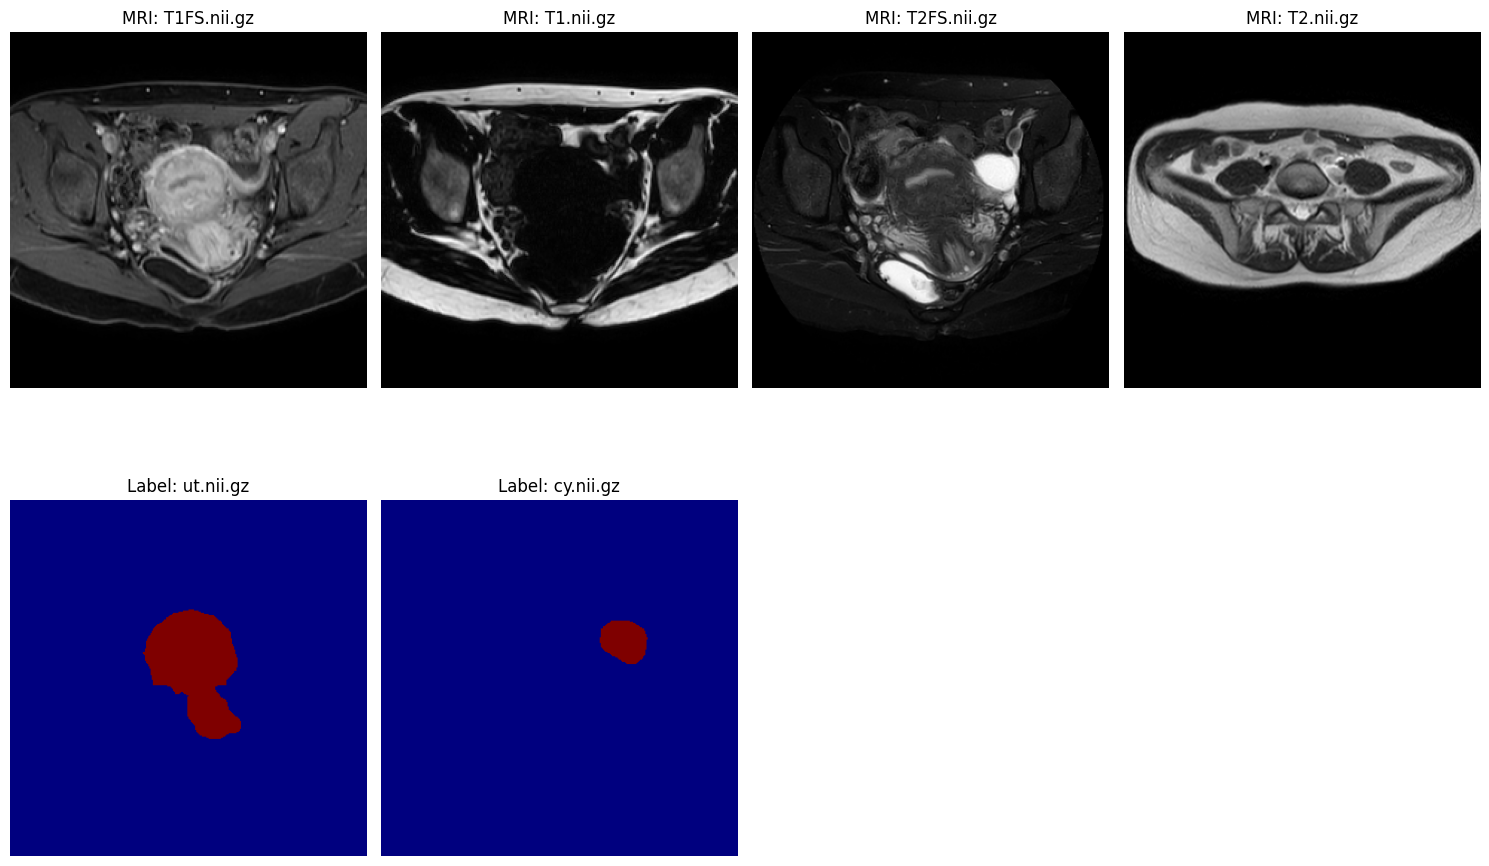

In [10]:
# 2. Visual Analysis of MRI Sequences and Annotations
def visualize_patient(patient_path):
    """Visualize all available sequences and annotations for a patient"""
    files = os.listdir(patient_path)
    mri_files = [f for f in files if any(seq in f for seq in ['T1', 'T2', 'T1FS', 'T2FS'])]
    label_files = [f for f in files if any(seq in f for seq in ['ut', 'ov', 'em', 'cy', 'cds'])]

    plt.figure(figsize=(15, 10))

    # Load and display MRI sequences
    for i, mri_file in enumerate(mri_files[:4]):  # Show max 4 sequences
        img = nib.load(os.path.join(patient_path, mri_file)).get_fdata()
        mid_slice = img.shape[2] // 2

        plt.subplot(2, 4, i+1)
        plt.imshow(img[:, :, mid_slice].T, cmap='gray')
        plt.title(f"MRI: {mri_file.split('_')[1]}")
        plt.axis('off')

    # Load and display annotations
    for j, label_file in enumerate(label_files[:4]):  # Show max 4 labels
        label = nib.load(os.path.join(patient_path, label_file)).get_fdata()
        mid_slice = label.shape[2] // 2

        plt.subplot(2, 4, j+5)
        plt.imshow(label[:, :, mid_slice].T, cmap='jet')
        plt.title(f"Label: {label_file.split('_')[1]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample patient
sample_patient = os.path.join(base_path, 'D2_TCPW', 'D2-006')
visualize_patient(sample_patient)

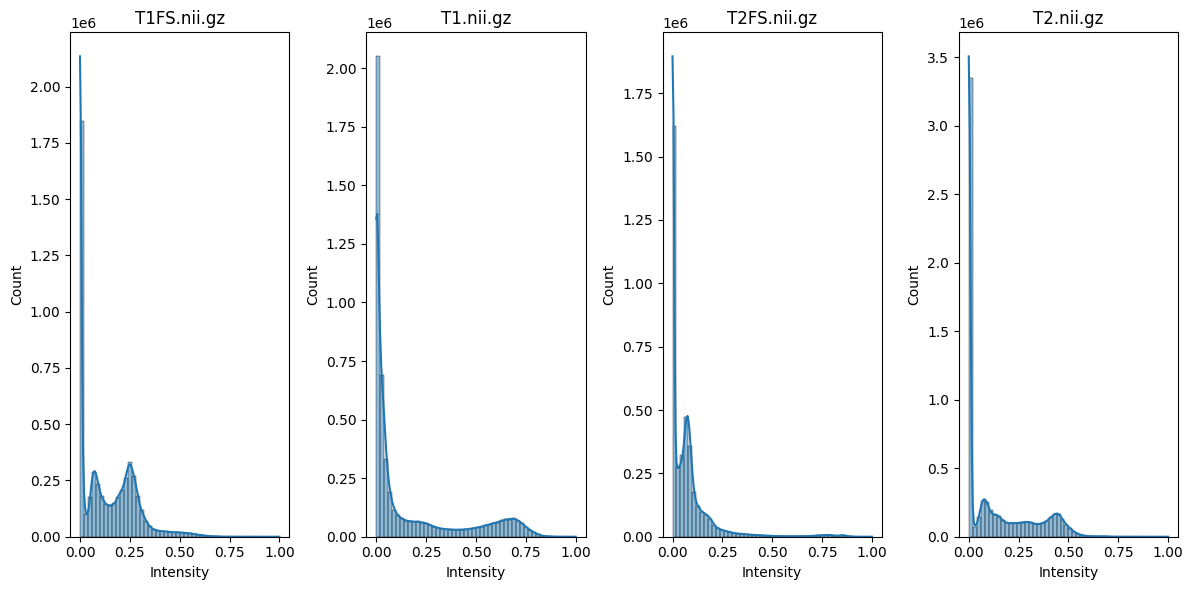

In [11]:

# 3. Intensity Distribution Analysis
def analyze_intensity_distribution(patient_path):
    """Analyze intensity distribution across sequences"""
    files = [f for f in os.listdir(patient_path) if any(seq in f for seq in ['T1', 'T2', 'T1FS', 'T2FS'])]

    plt.figure(figsize=(12, 6))
    for i, mri_file in enumerate(files):
        img = nib.load(os.path.join(patient_path, mri_file)).get_fdata()
        normalized = exposure.rescale_intensity(img, out_range=(0, 1))

        plt.subplot(1, len(files), i+1)
        sns.histplot(normalized.flatten(), bins=50, kde=True)
        plt.title(f"{mri_file.split('_')[1]}")
        plt.xlabel('Intensity')

    plt.tight_layout()
    plt.show()

analyze_intensity_distribution(sample_patient)


In [13]:
print(os.listdir(os.path.join(base_path, 'D2_TCPW')))

['.DS_Store', 'D2-059', 'D2-051', 'D2-045', 'D2-064', 'D2-063', 'D2-029', 'D2-009', 'D2-023', 'D2-058', 'D2-062', 'D2-039', 'D2-015', 'D2-024', 'D2-040', 'D2-073', 'D2-055', 'D2-018', 'D2-054', 'D2-011', 'D2-008', 'D2-049', 'D2-080', 'D2-010', 'D2-065', 'D2-056', 'D2-021', 'D2-014', 'D2-016', 'D2-002', 'D2-050', 'D2-012', 'D2-067', 'D2-038', 'D2-019', 'D2-043', 'D2-020', 'D2-026', 'D2-005', 'D2-076', 'D2-041', 'D2-000', 'D2-003', 'D2-046', 'D2-022', 'D2-078', 'D2-070', 'D2-060', 'D2-042', 'D2-004', 'D2-025', 'D2-068', 'D2-013', 'D2-077', 'D2-001', 'D2-044', 'D2-075', 'D2-057', 'D2-047', 'D2-006', 'D2-069', 'D2-048', 'D2-027', 'D2-053', 'D2-061', 'D2-079', 'D2-066', 'D2-074', 'D2-072', 'D2-071', 'D2-007', 'D2-052', 'D2-028', 'D2-017']


Analyzing annotations: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


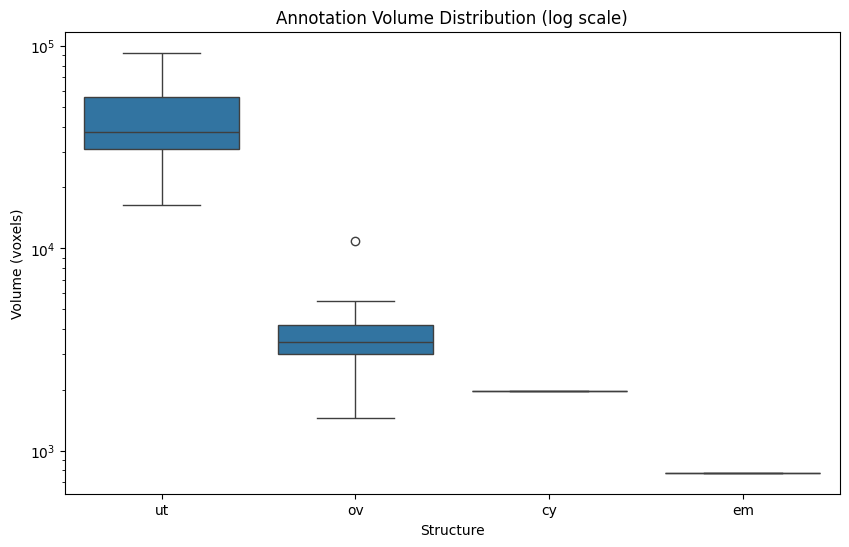

In [14]:
# 4. Annotation Analysis
# 4. Annotation Analysis (Fixed Version)
def analyze_annotations(dataset_path):
    """Quantitative analysis of annotation volumes"""
    volumes = []

    # Get only patient directories (filter out system files)
    patient_dirs = [d for d in os.listdir(dataset_path)
                   if d.startswith('D2-') and os.path.isdir(os.path.join(dataset_path, d))]

    for patient in tqdm(patient_dirs[:10], desc="Analyzing annotations"):  # Sample first 10 patients
        patient_path = os.path.join(dataset_path, patient)
        try:
            # Get only valid label files
            label_files = [f for f in os.listdir(patient_path)
                         if any(s in f for s in ['ut', 'ov', 'em', 'cy', 'cds'])
                         and f.endswith('.nii.gz')]

            if not label_files:
                print(f"No annotations found for patient {patient}")
                continue

            for label_file in label_files:
                try:
                    label = nib.load(os.path.join(patient_path, label_file)).get_fdata()
                    structure = label_file.split('_')[1].split('.')[0]
                    volumes.append({
                        'patient': patient,
                        'structure': structure,
                        'volume_voxels': np.sum(label > 0),
                        'volume_percent': 100 * np.mean(label > 0)
                    })
                except Exception as e:
                    print(f"Error processing {label_file} for patient {patient}: {str(e)}")
                    continue

        except Exception as e:
            print(f"Error processing patient {patient}: {str(e)}")
            continue

    if not volumes:
        print("No valid annotations found in the dataset")
        return None

    vol_df = pd.DataFrame(volumes)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=vol_df, x='structure', y='volume_voxels')
    plt.yscale('log')
    plt.title('Annotation Volume Distribution (log scale)')
    plt.ylabel('Volume (voxels)')
    plt.xlabel('Structure')
    plt.show()

    return vol_df

# Run the analysis with error handling
try:
    vol_df = analyze_annotations(os.path.join(base_path, 'D2_TCPW'))
except Exception as e:
    print(f"Error during annotation analysis: {str(e)}")
    vol_df = None

In [15]:
# 5. Preprocessing Pipeline for GRAD-CAM Preparation
def preprocess_for_gradcam(patient_path, target_size=(256, 256)):
    """Preprocess MRI and annotations for GRAD-CAM analysis"""
    # Load T2-weighted MRI (primary sequence for endometriosis)
    mri_file = [f for f in os.listdir(patient_path) if 'T2' in f and 'FS' not in f][0]
    img = nib.load(os.path.join(patient_path, mri_file)).get_fdata()

    # Load endometrioma annotation (primary target)
    em_file = [f for f in os.listdir(patient_path) if 'em' in f]
    if not em_file:
        print("No endometrioma annotation found")
        return None, None

    label = nib.load(os.path.join(patient_path, em_file[0])).get_fdata()

    # Select middle slice with pathology
    slice_idx = np.argmax(np.sum(label, axis=(0, 1)))
    img_slice = img[:, :, slice_idx]
    label_slice = label[:, :, slice_idx]

    # Normalize and resize
    img_normalized = cv2.normalize(img_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    img_resized = cv2.resize(img_normalized, target_size)

    label_resized = cv2.resize(label_slice.astype(np.float32), target_size)
    label_binary = (label_resized > 0.5).astype(np.uint8)

    # Convert to RGB for GRAD-CAM
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    img_rgb = img_rgb / 255.0  # Scale to [0,1]

    return img_rgb, label_binary

# Preprocess sample patient for GRAD-CAM
input_img, target_mask = preprocess_for_gradcam(sample_patient)

# Visualize preprocessed data
if input_img is not None:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_img)
    plt.title('Preprocessed MRI')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(target_mask, cmap='jet')
    plt.title('Endometrioma Mask')
    plt.axis('off')
    plt.show()

No endometrioma annotation found


In [16]:
# 6. Dataset Statistics Summary
print("\n=== Dataset Statistics Summary ===")
print(f"Total patients analyzed: {len(df)}")
print("\nSequence availability:")
print(df['sequences'].explode().value_counts())

print("\nLabel availability:")
print(df['labels'].explode().value_counts())

print("\nAnnotation volume statistics:")
print(vol_df.groupby('structure')['volume_voxels'].describe())


=== Dataset Statistics Summary ===
Total patients analyzed: 10

Sequence availability:
sequences
T2      8
T1FS    6
T1      5
T2FS    4
ut      4
ov      4
cy      2
Name: count, dtype: int64

Label availability:
labels
ov    11
ut    11
em     5
cy     2
Name: count, dtype: int64

Annotation volume statistics:
           count          mean           std      min      25%      50%  \
structure                                                                 
cy           2.0   1977.000000      8.485281   1971.0   1974.0   1977.0   
em           1.0    780.000000           NaN    780.0    780.0    780.0   
ov           8.0   4275.500000   2915.430720   1461.0   2995.0   3449.5   
ut           9.0  44820.555556  23111.008438  16360.0  30955.0  37493.0   

                75%      max  
structure                     
cy          1980.00   1983.0  
em           780.00    780.0  
ov          4198.25  10917.0  
ut         56125.00  92570.0  
